In [54]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [80]:
data = pd.read_csv("/content/drive/MyDrive/dl_practice/sentiment analysis.txt",
                   sep="\t", names=["review", "sentiment"])

In [81]:
data.head()

,review,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [82]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [83]:
def clean_text(text):
  stop = stopwords.words('english')
  lemmatize = WordNetLemmatizer()
  text = [lemmatize.lemmatize(word) for word in text.split() if word not in stop]
  cleaned_text = " ".join(text)
  return cleaned_text

In [84]:
data.review = data.review.apply(clean_text)

In [85]:
X = data.review
y = data.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [86]:
vocab_size = 1000
output_length = 256

In [87]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test)

In [94]:
model = Sequential()
model.add(Embedding(
    vocab_size,
    output_length
))
# model.add(LSTM(8))
model.add(SimpleRNN(8))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [95]:
model.compile(
    loss = 'binary_crossentropy', 
    optimizer='adam', 
    metrics = ['accuracy'])


In [96]:
callback = EarlyStopping(monitor='val_loss', patience=3)

In [97]:
history = model.fit(
    X_train,
    y_train,
    epochs=50, 
    batch_size=32,
    validation_data = (X_test, y_test),
    callbacks=[callback]
)

Epoch 1/50
22/22 [==============================] - 2s 30ms/step - loss: 0.7015 - accuracy: 0.5057 - val_loss: 0.6868 - val_accuracy: 0.5833
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 0.6741 - accuracy: 0.6414 - val_loss: 0.6672 - val_accuracy: 0.6333
Epoch 3/50
22/22 [==============================] - 0s 16ms/step - loss: 0.6069 - accuracy: 0.7700 - val_loss: 0.5881 - val_accuracy: 0.7667
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 0.4223 - accuracy: 0.8671 - val_loss: 0.4813 - val_accuracy: 0.7800
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 0.2163 - accuracy: 0.9271 - val_loss: 0.5398 - val_accuracy: 0.7567
Epoch 6/50
22/22 [==============================] - 0s 17ms/step - loss: 0.1136 - accuracy: 0.9557 - val_loss: 0.5954 - val_accuracy: 0.7733
Epoch 7/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0659 - accuracy: 0.9871 - val_loss: 0.6486 - val_accuracy: 0.7733


10/10 [==============================] - 0s 4ms/step
Accuracy Score:  78.66666666666666
ROC AUC Score: 78.66666666666666
Classification Report:                precision    recall  f1-score   support

           0       0.76      0.83      0.80       150
           1       0.82      0.74      0.78       150

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300



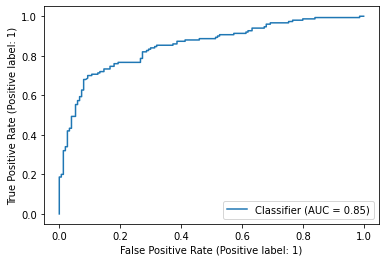

In [98]:
threshold = 0.7
y_pred = model.predict(X_test)

y_pred_test = np.where(y_pred >= threshold, 1, 0)
print("Accuracy Score: ", accuracy_score(y_test, y_pred_test)*100)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_test)*100)
print("Classification Report: ", classification_report(y_test, y_pred_test))
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

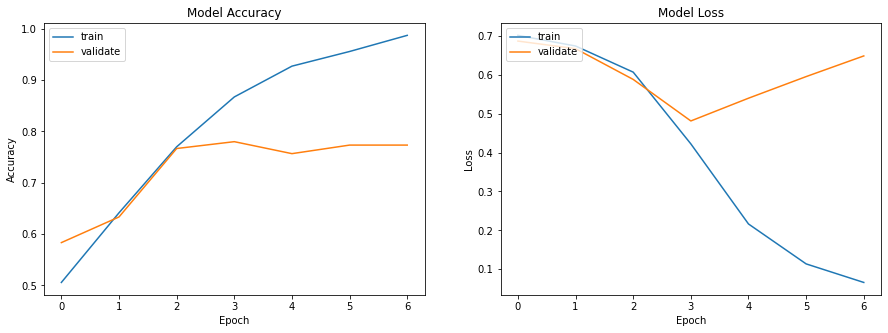

In [99]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

plotmodelhistory(history)